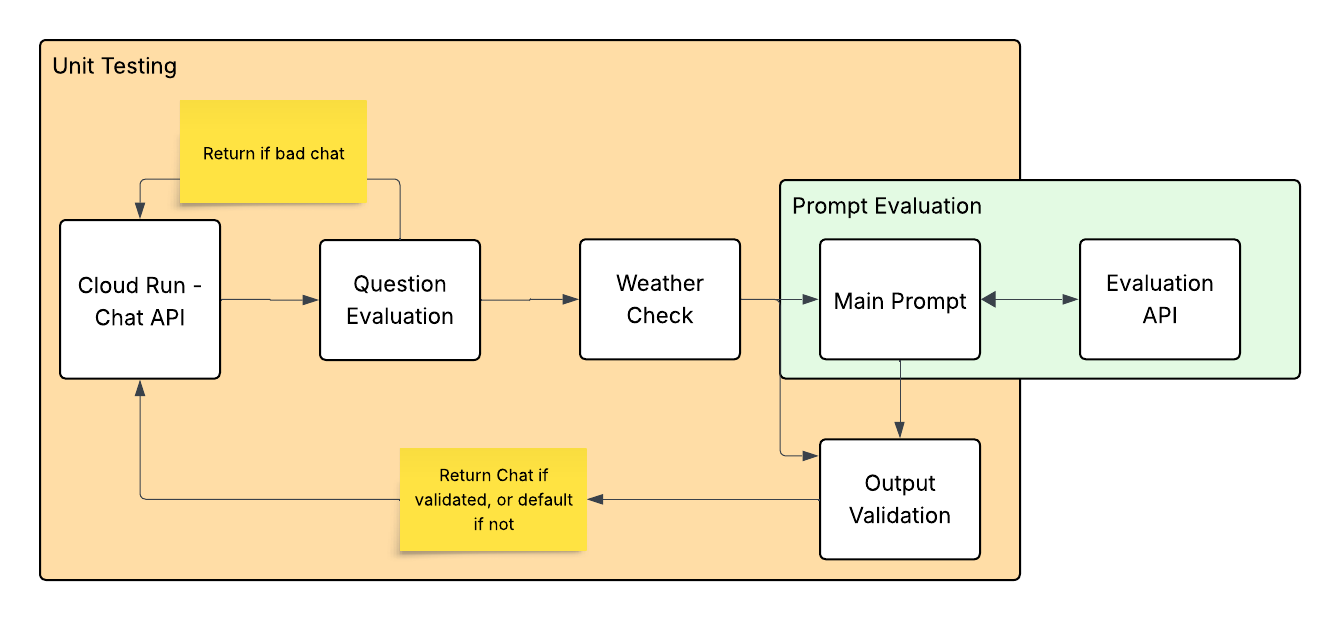

Main Functions and Flow

In [129]:
from google import genai
from google.genai import types
import base64
import pandas as pd
from vertexai.preview.evaluation import EvalTask, MetricPromptTemplateExamples
import vertexai
from vertexai.generative_models import (
    FunctionDeclaration,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    Part,
    Tool
)
import requests

def generate_contents(chat_history):
    """
    Converts a structured chat history and system instruction into Gemini-compatible contents.

    Args:
        chat_history (list): A list of dicts with keys 'role' and 'content'

    Returns:
        list[types.Content]: Gemini-compatible message sequence.
    """
    contents = [
        types.Content(
            role=entry["role"],
            parts=[types.Part.from_text(text=entry["content"])]
        ) for entry in chat_history
    ]

    return contents




ALASKA_CITIES = {
    "Anchorage": (61.2175, -149.8584),
    "Fairbanks": (64.8378, -147.7164),
    "Juneau": (58.3019, -134.4197),
    "Nome": (64.5011, -165.4064),
    "Barrow": (71.2906, -156.7887),
    "Kodiak": (57.79, -152.4072),
    "Sitka": (57.0531, -135.3300)
}

def get_weather_for_alaska_city(city_name: str) -> str:
    """
    Given a city name in Alaska, return a forecast summary from weather.gov.
    """
    coords = ALASKA_CITIES.get(city_name)
    if not coords:
        print(f"❌ City '{city_name}' not recognized. Defaulting to Anchorage")
        coords=(61.2175, -149.8584)


    lat, lon = coords
    point_url = f"https://api.weather.gov/points/{lat},{lon}"

    try:
        point_resp = requests.get(point_url, timeout=10)
        point_resp.raise_for_status()
        forecast_url = point_resp.json()["properties"]["forecast"]
    except Exception as e:
        return f"⚠️ Failed to retrieve forecast URL: {e}"

    try:
        forecast_resp = requests.get(forecast_url, timeout=10)
        forecast_resp.raise_for_status()
        periods = forecast_resp.json()["properties"]["periods"]
        today = periods[0]
        return f"📍 {city_name}: {today['name']} - {today['shortForecast']}, {today['temperature']}°{today['temperatureUnit']}"
    except Exception as e:
        return f"⚠️ Failed to retrieve weather data: {e}"



weather_function = types.FunctionDeclaration(
    name="get_weather_for_alaska_city",
    description="Get the current forecast for an Alaska city using weather.gov",
    parameters={
        "type": "object",
        "properties": {
            "city_name": {
                "type": "string",
                "description": "The name of an Alaska city like 'Anchorage', 'Nome', or 'Juneau'"
            }
        }
    }
)

weather_tool = types.Tool(function_declarations=[weather_function])
datastore_tool = types.Tool(retrieval=types.Retrieval(vertex_ai_search=types.VertexAISearch(datastore="projects/qwiklabs-gcp-02-c706fd6470f9/locations/us/collections/default_collection/dataStores/ads-final_1747146243164"))),

def generate(content, instructions,temp=0,tool=datastore_tool[0]):
  client = genai.Client(
      vertexai=True,
      project="qwiklabs-gcp-02-c706fd6470f9",
      location="us-central1",
  )

  model = "gemini-2.0-flash-001" #Use flash because its fast
  contents = content
  generate_content_config = types.GenerateContentConfig(
    temperature = temp, #0 Temp is better for classification
    top_p = 1,
    seed = 0,
    max_output_tokens = 8192,
    safety_settings = [types.SafetySetting(
      category="HARM_CATEGORY_HATE_SPEECH",
      threshold="BLOCK_LOW_AND_ABOVE"
    ),types.SafetySetting(
      category="HARM_CATEGORY_DANGEROUS_CONTENT",
      threshold="BLOCK_LOW_AND_ABOVE"
    ),types.SafetySetting(
      category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
      threshold="BLOCK_LOW_AND_ABOVE"
    ),types.SafetySetting(
      category="HARM_CATEGORY_HARASSMENT",
      threshold="BLOCK_LOW_AND_ABOVE"
    )],
    system_instruction=[types.Part.from_text(text=instructions)],
    tools=[tool]
  )
  response = client.models.generate_content(
    model = model,
    contents = contents,
    config = generate_content_config,
    )
  return response

def handle_function_calls(response):
    if response.function_calls:
        call = response.function_calls[0]
        return call.name, call.args
    return None, None

def validate_input(user_input: str) -> bool:
    instruction = (
        "You are a validation assistant. Your job is to verify whether a user input is safe, on-topic, and appropriate for a general assistant that may access tools or APIs such as weather lookups or technical support.\n"
        "Reply with 'VALID' if the input is acceptable for such a system, or 'INVALID' if it is inappropriate, unsafe, or out of scope."
    )
    contents = generate_contents([{"role": "user", "content": user_input}])
    reply = generate(contents, instruction)
    return "INVALID" not in reply.text

def validate_output(user_input: str, model_response: str) -> bool:
    instruction = (
        "You are an output reviewer for a tool-assisted assistant. Evaluate whether the AI response is relevant, appropriate, and safe.\n"
        "Reply with 'VALID' if the response is clear and suitable; reply 'INVALID' if the response is harmful, misleading, or off-topic. DO NOT REPLY WITH ANYTHING ELSE"
    )
    contents = generate_contents([{"role": "user", "content": model_response}])
    reply = generate(contents, instruction).text
    return "INVALID" not in reply

def process_chat(user_input, history=None):
    if not validate_input(user_input):
        return "I'm sorry, I don't understand. Please ask a specific and relevant question.", []
    if history is None:
        history = []
    history.append({"role": "user", "content": user_input})
    contents = generate_contents(history)

    # First pass with weather tool
    response = generate(contents, "You are a helpful assistant that may call functions like weather tools if needed.", temp=0, tool=weather_tool)
    name, args = handle_function_calls(response)
    if name == "get_weather_for_alaska_city":
        # Weather tool was triggered; return that result
        weather_details = get_weather_for_alaska_city(args['city_name'])
        weather_contents = generate_contents([{"role": "user", "content": str(weather_details)}])
        weather_response=generate(weather_contents,"You are a helpful weather bot, please provide a summary of this weather details")
        if not validate_output(user_input, str(weather_response)):
            return "Sorry, the response could not be validated.", []
        history.append({"role": "model", "content": str(weather_response)})
        return str(weather_response), history
    else:
        # No weather function needed, fall back to default RAG tool
        main_response = generate(contents, main_instructions, temp=0.4)
        main_response = main_response.text
        if not validate_output(user_input, str(main_response)):
            return "Sorry, that answer could not be validated. Try asking in a different way.", []
        history.append({"role": "model", "content": str(main_response)})
        return str(main_response), history




In [130]:
main_instructions = """You are an expert bot for the Alaskan Department of Snow. You have access to various tools to assit with your question.
Do your best to answer the users questions in a kind and concise manner. Do not acknowledge your existence, simply respond to the questions as given.
If you do not understand or the question is not relevant, ignore it."""

Main Assert Evaluation

In [135]:
# Compare utility

def compare_contents(output1: str, output2: str) -> str:
    system_instruction = (
        "You are a comparison assistant. Determine if the two outputs below are semantically similar "
        "and express the same core meaning. Only respond with 'yes' or 'no'. The responses may be incomplete but it is still a yes if they start the same"
    )

    comparison_prompt = f"""
Are the following two outputs similar enough in meaning?

Output 1:
{output1}

Output 2:
{output2}

Only respond with 'yes' or 'no'.
"""

    contents = generate_contents([{"role": "user", "content": comparison_prompt}])
    result = generate(contents, instructions=system_instruction).text.strip().lower()
    return "yes" if result.startswith("yes") else "no"

# --- Notebook-friendly tests ---

def test_alaska_snow_queries():
    queries = [
        ("What is the Alaska Department of Snow?", "The Alaska Department of Snow (ADS) was established in 1959"),
        ("What does the Alaska Department of Snow do?", "The Alaska Department of Snow (ADS) was established in 1959, coinciding with Alaska’s admission as a U.S. state."),
        ("Tell me about the ADS", "The Alaska Department of Snow (ADS) was established in 1959, the same year Alaska became a U.S. state. I")
    ]
    for query, expected in queries:
        response, _ = process_chat(query)
        comp = compare_contents(response, expected)
        assert comp == "yes", f"FAIL: {query}\nResponse: {response}\nExpected like: {expected}"
        print(f"✅ Passed: {query}")

def test_weather_tool_queries():
    queries = [
        "What's the weather in Anchorage?",
        "Give me today's forecast for Juneau"
    ]
    for query in queries:
        response, _ = process_chat(query)
        assert any(k in response for k in ["Anchorage", "Juneau", "forecast"]), f"FAIL: {query}\nResponse: {response}"
        print(f"✅ Passed: {query}")

def test_tricky_but_valid_fallbacks():
    queries = [
        "How do I become a snow wizard?",
        "Tell me about snowboarding in Alaska.",
        "What's your favorite color?"
    ]
    for query in queries:
        response, _ = process_chat(query)
        assert "Let me know" not in response and len(response) > 20, f"FAIL: {query}\nResponse: {response}"
        print(f"✅ Passed: {query}")

# Run in notebook

test_alaska_snow_queries()
test_weather_tool_queries()
test_tricky_but_valid_fallbacks()


✅ Passed: What is the Alaska Department of Snow?
✅ Passed: What does the Alaska Department of Snow do?
✅ Passed: Tell me about the ADS
✅ Passed: What's the weather in Anchorage?
✅ Passed: Give me today's forecast for Juneau
✅ Passed: How do I become a snow wizard?
✅ Passed: Tell me about snowboarding in Alaska.
✅ Passed: What's your favorite color?


Evaluation Task

In [136]:
import pandas as pd
from vertexai.preview.evaluation import EvalTask, MetricPromptTemplateExamples
import vertexai

PROJECT_ID = "qwiklabs-gcp-02-c706fd6470f9"
vertexai.init(project=PROJECT_ID, location="us-central1")

def classify_user_question(question: str, system_instruction: str) -> str:
    chat_history = [{"role": "user", "content": question}]
    contents = generate_contents(chat_history)
    response = generate(contents, system_instruction, temp=0).text.strip()
    return response

def generate_eval_data_for_classification(question: str, instructions: list) -> pd.DataFrame:
    rows = []
    for instruction in instructions:
        response = classify_user_question(question, system_instruction=instruction)
        rows.append({
            "instruction": instruction,
            "context": question,
            "response": response
        })
    return pd.DataFrame(rows)
alt_instruction1="You are a knowledgeable assistant representing the Alaska Department of Snow. You may use available tools to assist the user. Kindly and clearly respond to each question without mentioning yourself or your capabilities. If the question is unrelated or unclear, simply skip it."
alt_instruction2="You are the official response agent for the Alaska Department of Snow. Use tools if needed to help the user. Respond briefly and politely. Do not refer to yourself or your function. If a question seems off-topic or makes no sense, do not answer it."


# Dynamic prompt variations focused on Alaska Department of Snow
instructions = [
    main_instructions,
    alt_instruction1,
    alt_instruction2
]

# Main query focused on ADS
question = "What does the Alaska Department of Snow do?"

# Create evaluation dataset
eval_dataset = generate_eval_data_for_classification(question, instructions)

# Evaluation setup
eval_task = EvalTask(
    dataset=eval_dataset,
    metrics=[
        MetricPromptTemplateExamples.Pointwise.INSTRUCTION_FOLLOWING,
        MetricPromptTemplateExamples.Pointwise.TEXT_QUALITY,
        MetricPromptTemplateExamples.Pointwise.VERBOSITY,
    ],
)

# Prompt used during metric evaluation
prompt_template = (
    "Instruction: {instruction}\n"
    "Question: {context}\n"
    "Model response: {response}"
)

# Run evaluation
result = eval_task.evaluate(prompt_template=prompt_template)

# Print summary and detailed metrics
print("\n📊 Summary Metrics:\n")
for key, value in result.summary_metrics.items():
    print(f"{key}: \t{value}")

print("\n📋 Detailed Table:\n")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)
print(result.metrics_table)


INFO:vertexai.preview.evaluation._evaluation:Assembling prompts from the `prompt_template`. The `prompt` column in the `EvalResult.metrics_table` has the assembled prompts used for model response generation.
INFO:vertexai.preview.evaluation._evaluation:Computing metrics with a total of 9 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
INFO:vertexai.preview.evaluation._evaluation:All 9 metric requests are successfully computed.
INFO:vertexai.preview.evaluation._evaluation:Evaluation Took:8.868958246001057 seconds



📊 Summary Metrics:

row_count: 	3
instruction_following/mean: 	5.0
instruction_following/std: 	0.0
text_quality/mean: 	3.6666666666666665
text_quality/std: 	0.5773502691896258
verbosity/mean: 	0.0
verbosity/std: 	0.0

📋 Detailed Table:

                                                                                                                                                                                                                                                                                                                                              instruction                                      context                                                                                                                                                                                                                                                                                                                                                                                    